In [2]:
using PyPlot, LinearAlgebra
include("code/acoustic_solver_parallel.jl")
include("code/Mixed_Wasserstein.jl")
include("code/optimization.jl")

update_fn (generic function with 1 method)

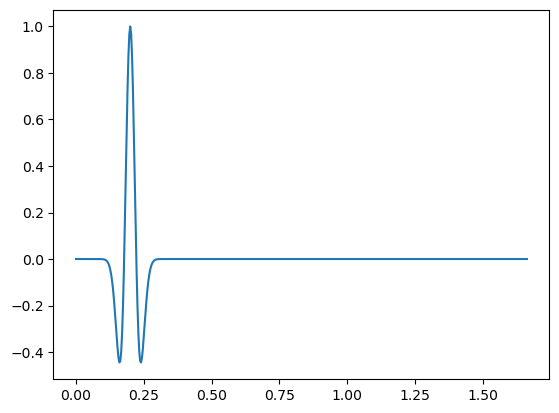

CFL: 0.6


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fa785fdd1c0>

In [3]:
Nx = 101
Ny = 101
c_true = 3*ones(Nx,Ny)
for i = 1:Nx
    for j = 1:Ny
        if (i-51)^2+(j-51)^2 < 25^2
            c_true[i,j] = 3.6
        end
    end
end
c = 3*ones(Nx,Ny)
rho_true = ones(Nx,Ny)
rho = ones(Nx,Ny)
h = 0.02

# time
Fs = 300;
dt = 1/Fs;
Nt = 500;
t = range(0,length=Nt,step=dt);
println("CFL: ", maximum(c_true) * dt / h);

# source
source = source_ricker(10,0.2,t)
source_num = 11
source_position = zeros(Int,source_num,2)
for i = 1:source_num
        source_position[i,:] = [(i-1)*10+1,1]
end
source = repeat(source, 1, 1);

# receiver
receiver_num = 101
receiver_position = zeros(Int,receiver_num,2)
for i = 1:receiver_num
    receiver_position[i,:] = [(i-1)+1,101]
end

# PML
pml_len = 30
pml_coef = 50

plot(t, source[:,1])

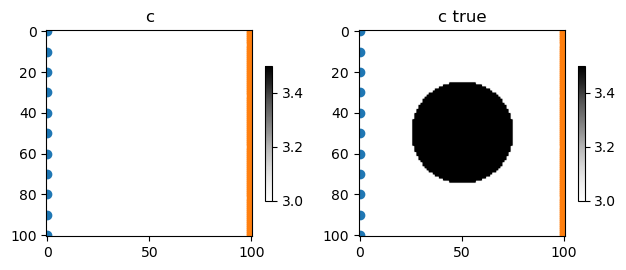

In [4]:
figure;

cmap_name = "Greys"
subplot(121); imshow(c, cmap=cmap_name); title("c"); colorbar(shrink=0.3); clim(3,3.5)
scatter(source_position[:,2].-1, source_position[:,1].-1)
scatter(receiver_position[:,2].-1, receiver_position[:,1].-1)

subplot(122); imshow(c_true, cmap=cmap_name); title("c true"); colorbar(shrink=0.3); clim(3,3.5)
scatter(source_position[:,2].-1, source_position[:,1].-1)
scatter(receiver_position[:,2].-1, receiver_position[:,1].-1)

tight_layout()

Computing received data.


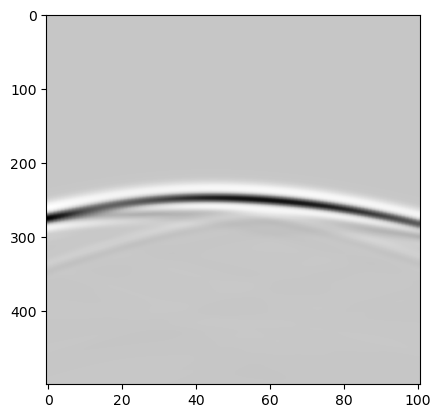

  6.829609 seconds (13.17 M allocations: 682.513 MiB, 3.52% gc time)
Received data done.


PyObject <matplotlib.image.AxesImage object at 0x7fa770017ee0>

In [5]:
# make data
println("Computing received data.")
@time received_data = multi_solver_no_wavefield(c_true, rho_true, Nx, h, Ny, h, Nt, dt, source, source_position, receiver_position; pml_len=pml_len, pml_coef=pml_coef);
println("Received data done.")
imshow(received_data[:,:,5], cmap=cmap_name, aspect=0.2)

In [6]:
# make data
ind = 6
println("Computing received data.")
@time u, data_forward = acoustic_solver(c, rho, Nx, h, Ny, h, Nt, dt, source, source_position[ind,:]', receiver_position; pml_len=pml_len, pml_coef=pml_coef)
println("Received data done.")

Computing received data.
  1.580100 seconds (1.55 M allocations: 110.932 MiB, 6.54% gc time)
Received data done.


In [7]:
# adj_source_mixed_tbyt
# Mixed_Wasserstein(a, b, eps, lambda_mix, M; threshold=1e-5, iter_num=iteration_number, verbose=false);
eps = 1e-4
lambda_mix = 1e-10
M = cost_matrix_1d(t, t; p=2)
iteration_number = 1000
k_normalize = 1e3

ind = 6
adj_source = 0 .* received_data
for i = 1:size(received_data[:,:,ind],2)
    b = received_data[:,i,ind]
    a = data_forward[:,i]
    grad_exp, dist_exp = Mixed_Wasserstein_exp(a, b, eps, lambda_mix, M, k_normalize; threshold=1e-5, iter_num=iteration_number, verbose=false);
    adj_source[:,i,ind] = grad_exp'
end

In [8]:

function adj_source_mixed_tbyt(data_forward, received_data, eps, lambda_mix, M; iter_num=500)
    
    adj_source = 0 .* received_data
    
    @views @inbounds for i = 1:size(received_data,2)
        b = received_data[:,i]
        a = data_forward[:,i]
        grad_exp, dist_exp = Mixed_Wasserstein_exp(a, b, eps, lambda_mix, M, k_normalize; iter_num=iter_num, verbose=false);
        adj_source[:,i] = grad_exp'
    end

    return -adj_source
end

adj_source_mixed_tbyt (generic function with 2 methods)

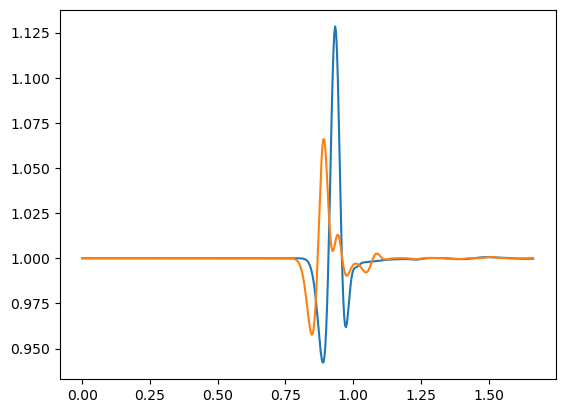

2-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fa7701aba90>
 PyObject <matplotlib.lines.Line2D object at 0x7fa7701aba30>

In [37]:
eps = 5e-5
lambda_mix = 1e-10
M = cost_matrix_1d(t, t; p=2)
iteration_number = 500
k_normalize = 1e4
i = 10
b = received_data[:,i,ind]
a = data_forward[:,i]

a_exp = exp.(k_normalize .* a)
b_exp = exp.(k_normalize .* b)

plot(t, a_exp, t, b_exp)

In [38]:
@time adj_s = adj_source_mixed_tbyt(data_forward, received_data[:,:,6], eps, lambda_mix, M, k_normalize; iter_num=iteration_number);

  3.970038 seconds (356.85 k allocations: 1.754 GiB, 6.08% gc time)


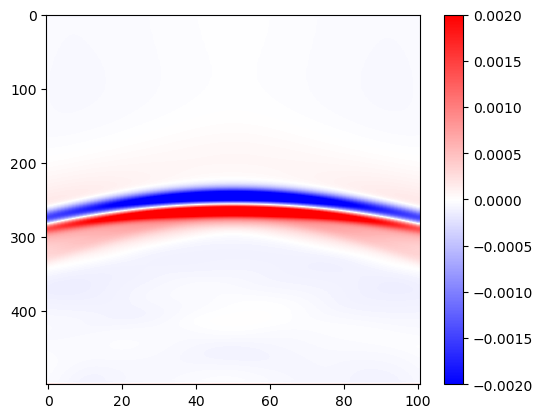

In [66]:
imshow(adj_s[2], aspect=0.2, cmap="bwr"); colorbar(); 
clim(-0.002, 0.002)

In [69]:
@save "ex3_file/adj_source.jld2" adj_s Nt Nx Ny t h

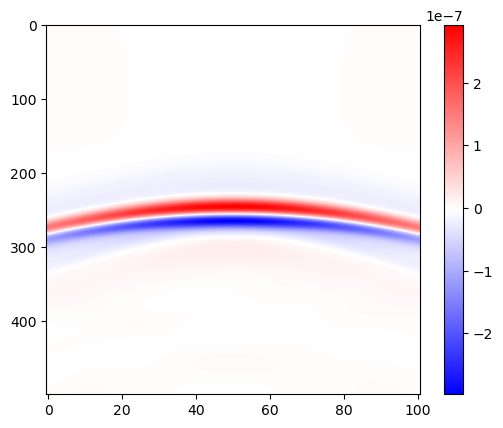

In [547]:
imshow(-adj_s[2], aspect=0.2, cmap="bwr"); colorbar(); 
# clim(-0.0010, 0.003)

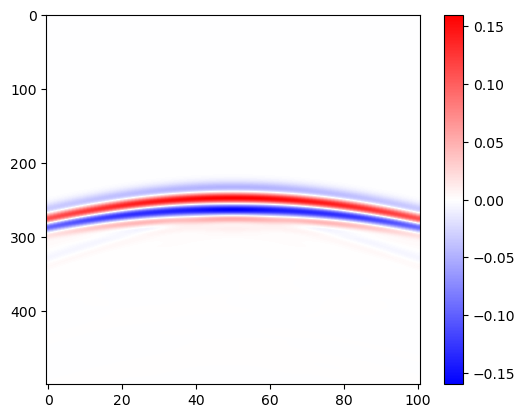

In [322]:
l2_source = received_data[:,:,ind] - data_forward
imshow(l2_source * 1e4, aspect=0.2, cmap="bwr"); colorbar(); 

In [49]:
include("code/Mixed_Wasserstein.jl")
include("code/adjoint_method.jl")
include("code/optimization.jl")

eps = 5e-5
lambda_mix = 1e-10
M = cost_matrix_1d(t, t; p=2)
iteration_number = 500
k_normalize = 1e4

compute_adj_source_mixed_tbyt(data_forward, received_data) = adj_source_mixed_tbyt(data_forward, received_data, eps, lambda_mix, M, k_normalize; iter_num=500)



compute_adj_source_mixed_tbyt (generic function with 1 method)

In [41]:

eval_fn_ot(x) = eval_obj_fn_mixed_exp(received_data, x, rho, Nx, h, Ny, h, Nt, dt, source, source_position, receiver_position, compute_adj_source_mixed_tbyt; pml_len=30, pml_coef=50)

eval_grad_ot(x) = compute_gradient_mixed_exp(received_data, x, rho, Nx, h, Ny, h, Nt, dt, source, source_position, receiver_position, compute_adj_source_mixed_tbyt; pml_len=30, pml_coef=50)


eval_grad_ot (generic function with 1 method)

In [43]:
@time ddd, gg_ott = eval_grad_ot(c);

 66.644651 seconds (16.17 M allocations: 21.238 GiB, 8.00% gc time)


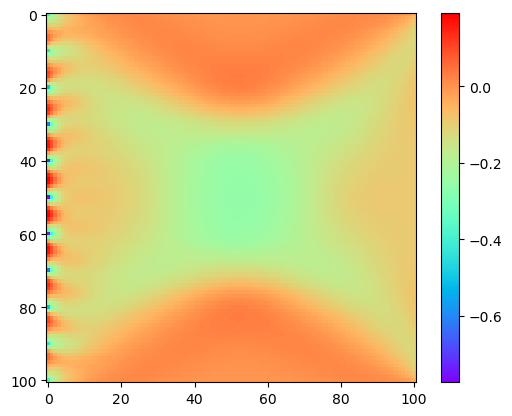

PyObject <matplotlib.colorbar.Colorbar object at 0x7fa740370490>

In [48]:
imshow(2e8 * reshape(gg_ott,Nx,Ny), cmap="rainbow"); colorbar()

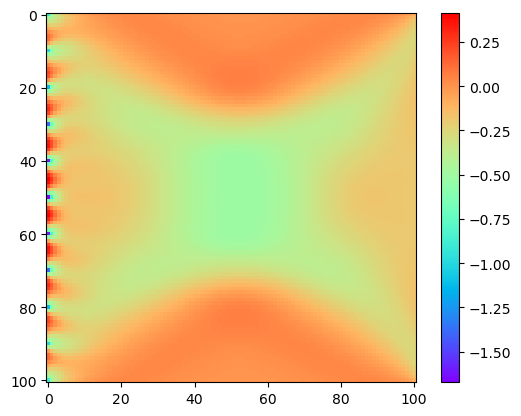

PyObject <matplotlib.colorbar.Colorbar object at 0x7fe80a0b1610>

In [555]:
imshow(5e12 * reshape(gg_ott,Nx,Ny), cmap="rainbow"); colorbar()

In [50]:
include("code/optimization.jl")

min_value = 0
max_value = 10
alpha = 2e8
iterNum = 5
rhorho = 0.1
cc = 1e-15
maxSearchTime = 2
x0 = reshape(c, Nx*Ny, 1);

xk_ot, fn = LBFGS(eval_fn_ot, eval_grad_ot, x0, alpha, iterNum, min_value, max_value; m=5, alpha_search=1, rho=rhorho, c=cc, maxSearchTime=maxSearchTime, threshold=1e-10)



Main iteration: 1
Start line search. fk: 2.78902e-02
    alpha: 2.00000e+08    fk1: 2.77314e-02    fk-c*alpha*gradk^2: 2.78902e-02
Line search succeed. Search time: 0.
----------------------------------------------------------------
Start LBFGS.
----------------------------------------------------------------
Main iteration: 2
Start line search. fk: 2.77314e-02
    alpha: 1.00000e+00    fk1: 2.78186e-02    fk-c*alpha*gradk^2: 2.77314e-02
    alpha: 1.00000e-01    fk1: 2.77084e-02    fk-c*alpha*gradk^2: 2.77314e-02
Line search succeed. Search time: 1.
----------------------------------------------------------------
Main iteration: 3
Start line search. fk: 2.77084e-02
    alpha: 1.00000e+00    fk1: 2.76917e-02    fk-c*alpha*gradk^2: 2.77084e-02
Line search succeed. Search time: 0.
----------------------------------------------------------------
Main iteration: 4
Start line search. fk: 2.76917e-02
    alpha: 1.00000e+00    fk1: 2.76901e-02    fk-c*alpha*gradk^2: 2.76917e-02
Line search su

([3.7034989593466956, 3.395298939956932, 3.239556713617623, 3.1344820078206026, 3.0420081437015463, 2.9469937689526824, 2.85603905089723, 2.8096448628436947, 2.8759350115079343, 3.0995299253571056  …  3.1219729576435364, 3.1313268321325713, 3.139664155787514, 3.1462924335800824, 3.150495929573471, 3.1514853448919737, 3.1482492946969787, 3.139088684257969, 3.1205107804464904, 3.0842937129793757], [0.027890222208835348, 0.027731384248875685, 0.02770837544339617, 0.027691667196098325, 0.027690136751163393, 0.02768927660713758])

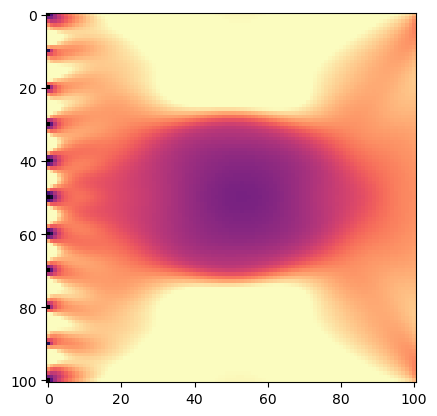

In [57]:
imshow(reshape(xk_ot, Nx, Ny), cmap="magma_r"); clim(3,3.6)

In [64]:
@load "temp_data/data_iter_5.jld2"

2-element Array{Symbol,1}:
 :xk
 :ggk

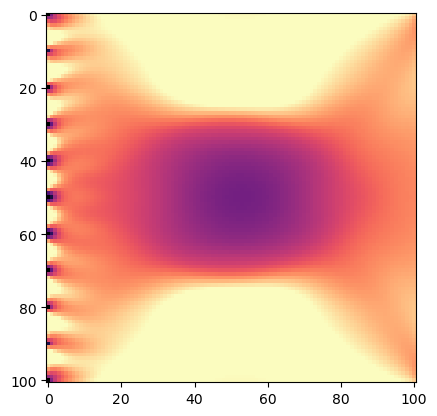

In [65]:
# c1 = c - alpha * reshape(gg_ott, Nx, Ny)
imshow(reshape(xk, Nx, Ny), cmap="magma_r"); clim(3,3.6)

In [503]:
@time u, data_forward = acoustic_solver(c1, rho, Nx, h, Ny, h, Nt, dt, source, source_position[ind,:]', receiver_position; pml_len=pml_len, pml_coef=pml_coef)



  0.407312 seconds (7.80 k allocations: 44.558 MiB, 18.89% gc time)


([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

[-12403.981703156245 31139.2102563034 … -9.500622521689907e-9 -1.9433638623835842e-8; -85599.39734410544 -13031.412057661099 … -1.8679905558043984e-9 -1.246640183671778e-8; … ; -425382.28116357815 -293329.1451649315 … -6.880357650996913e-9 -1.4762814538874398e-8; -243775.96448528251 -159098.58993881312 … -9.315174368439195e-9 -1.6725508514965938e-8]

[-72682.50867895679 -3845.8188832249944 … -2.9527153965214966e-9 -1.3303109631501968e-8; -177001.2639880932 -67273.01504748456 … 4.0945581360244785e-9 -5.776440250117361e-9; … ; -623746.2499794824 -432657.5233814922 … -3.753364079728908e-9 -1.0782919133057896e-8; -371681.706307063 -248648.46672635694 … -5.610479460373833e-9 -1.3070406601741241e-8]

[-159686.78618977347 -56134.383207596824 … 3

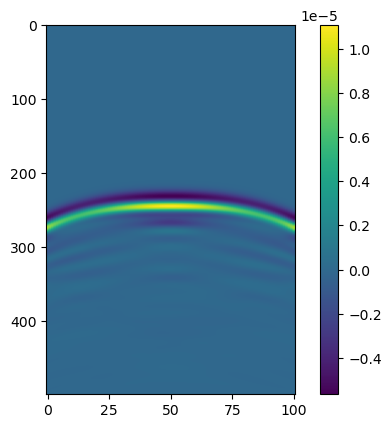

In [506]:
imshow(data_forward[:,:],aspect=0.3); colorbar(); 
# clim(-1e-4,1e-4)